In [29]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import time
from tqdm import tqdm

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)  # (x - 0.5) / 0.5 = 2x - 1
])

mnist_train = torchvision.datasets.MNIST(
    root='./mnist_data', 
    train=True, 
    download=True, 
    transform=transform
)

mnist_test = torchvision.datasets.MNIST(
    root='./mnist_data', 
    train=False, 
    download=True, 
    transform=transform
)

print(f"Training samples: {len(mnist_train)}")
print(f"Test samples: {len(mnist_test)}")

Training samples: 60000
Test samples: 10000


In [31]:
# Set up DataLoaders
batch_size = 32  # Adjust based on your CPU capacity
train_loader = DataLoader(
    mnist_train, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=2  # Adjust based on your CPU
)

test_loader = DataLoader(
    mnist_test, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=2
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 1875
Number of test batches: 313


In [32]:
class Generator(nn.Module):
    """
    Generator network for MNIST GAN
    Maps noise vector z (dim 100) to fake images (28x28 = 784)
    Architecture: 100 -> 256 -> 512 -> 784
    """
    def __init__(self, noise_dim=100, hidden_dim1=256, hidden_dim2=512, output_dim=784):
        super(Generator, self).__init__()
        
        self.noise_dim = noise_dim
        self.output_dim = output_dim
        
        # Define layers
        self.fc1 = nn.Linear(noise_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)  # Optional batch normalization
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        
        self.fc3 = nn.Linear(hidden_dim2, output_dim)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights following DCGAN paper recommendations"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.normal_(m.weight, 1.0, 0.02)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, z):
        """
        Forward pass through generator
        Args:
            z: Noise vector of shape [batch_size, noise_dim]
        Returns:
            Generated images of shape [batch_size, 1, 28, 28]
        """
        # First hidden layer
        x = self.fc1(z)
        x = self.bn1(x)
        x = F.relu(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        
        # Output layer
        x = self.fc3(x)
        x = torch.tanh(x)  # Output in [-1, 1] to match normalized MNIST
        
        # Reshape to image format [batch_size, 1, 28, 28]
        x = x.view(-1, 1, 28, 28)
        
        return x

class Discriminator(nn.Module):
    """
    Discriminator network for MNIST GAN
    Maps flattened images (784) to probability of being real
    Architecture: 784 -> 256 -> 256 -> 1
    """
    def __init__(self, input_dim=784, hidden_dim1=256, hidden_dim2=256, dropout_prob=0.3):
        super(Discriminator, self).__init__()
        
        self.input_dim = input_dim
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.dropout1 = nn.Dropout(dropout_prob)
        
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(dropout_prob)
        
        self.fc3 = nn.Linear(hidden_dim2, 1)
        
        # Initialize weights
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights following DCGAN paper recommendations"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0.0, 0.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """
        Forward pass through discriminator
        Args:
            x: Images of shape [batch_size, 1, 28, 28] or [batch_size, 784]
        Returns:
            Probability of being real [batch_size, 1]
        """
        # Flatten if needed
        if len(x.shape) == 4:  # [batch_size, 1, 28, 28]
            x = x.view(x.size(0), -1)  # [batch_size, 784]
        
        # First hidden layer
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.dropout1(x)
        
        # Second hidden layer
        x = self.fc2(x)
        x = F.leaky_relu(x, negative_slope=0.2)
        x = self.dropout2(x)
        
        # Output layer
        x = self.fc3(x)
        x = torch.sigmoid(x)  # Output probability [0, 1]
        
        return x


Testing training setup...
GAN Trainer initialized:
  Learning rate: 0.0002
  Adam betas: (0.5, 0.999)
  Label smoothing: True
  Smooth real labels: 0.9
  Device: cuda

Testing discriminator training...
D stats: {'loss_D_total': 1.3808674812316895, 'loss_D_real': 0.6876251697540283, 'loss_D_fake': 0.6932422518730164, 'real_predictions': 0.5035420656204224, 'fake_predictions': 0.5000424385070801}

Testing generator training...
G stats: {'loss_G': 0.6947005987167358, 'fake_predictions_for_G': 0.4990367889404297}

Testing sample generation...
Generated samples shape: torch.Size([16, 1, 28, 28])
Samples range: [-0.056, 0.063]

✓ Training setup verified and ready!
GAN Trainer initialized:
  Learning rate: 0.0002
  Adam betas: (0.5, 0.999)
  Label smoothing: True
  Smooth real labels: 0.9
  Device: cuda

Starting GAN training for 50 epochs...

Epoch 1/50


Training: 100%|██████████| 1875/1875 [01:11<00:00, 26.39it/s, D_loss=1.0504, G_loss=1.2306, D(x)=0.591, D(G(z))=0.332] 


Epoch 1 Summary:
  Generator Loss: 1.1753
  Discriminator Loss: 1.1643
    - Real Loss: 0.6523
    - Fake Loss: 0.5120


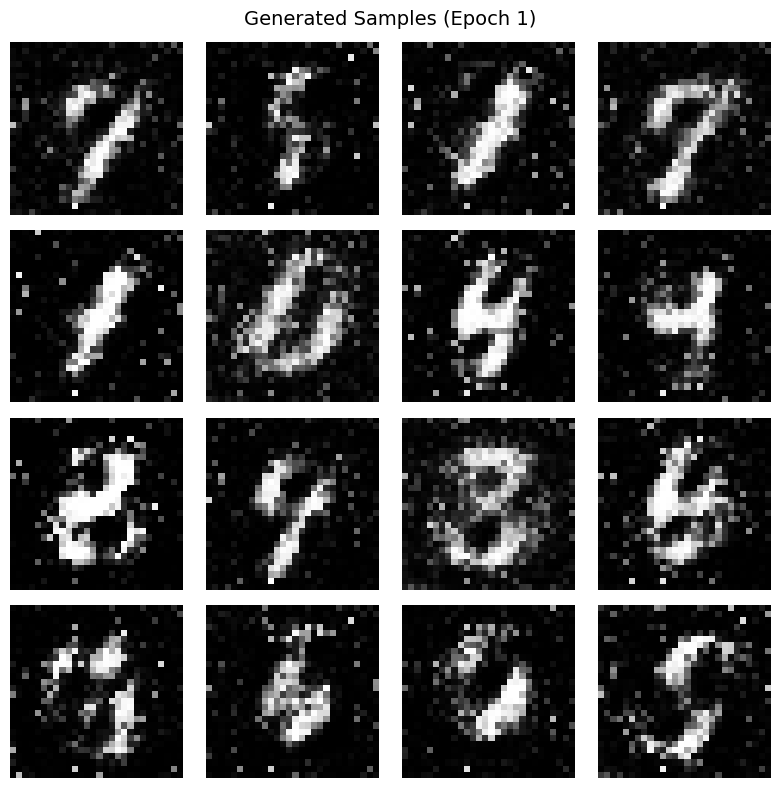


Epoch 2/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 91.40it/s, D_loss=1.3293, G_loss=1.0327, D(x)=0.592, D(G(z))=0.475] 


Epoch 2 Summary:
  Generator Loss: 1.1707
  Discriminator Loss: 1.1720
    - Real Loss: 0.7003
    - Fake Loss: 0.4717

Epoch 3/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 91.68it/s, D_loss=1.2428, G_loss=1.0686, D(x)=0.523, D(G(z))=0.377] 


Epoch 3 Summary:
  Generator Loss: 1.0513
  Discriminator Loss: 1.2179
    - Real Loss: 0.7180
    - Fake Loss: 0.4999

Epoch 4/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 92.97it/s, D_loss=1.2285, G_loss=1.0686, D(x)=0.434, D(G(z))=0.292] 


Epoch 4 Summary:
  Generator Loss: 1.0028
  Discriminator Loss: 1.2430
    - Real Loss: 0.7280
    - Fake Loss: 0.5149

Epoch 5/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 92.49it/s, D_loss=1.4574, G_loss=0.9584, D(x)=0.480, D(G(z))=0.449] 


Epoch 5 Summary:
  Generator Loss: 0.9536
  Discriminator Loss: 1.2744
    - Real Loss: 0.7395
    - Fake Loss: 0.5349


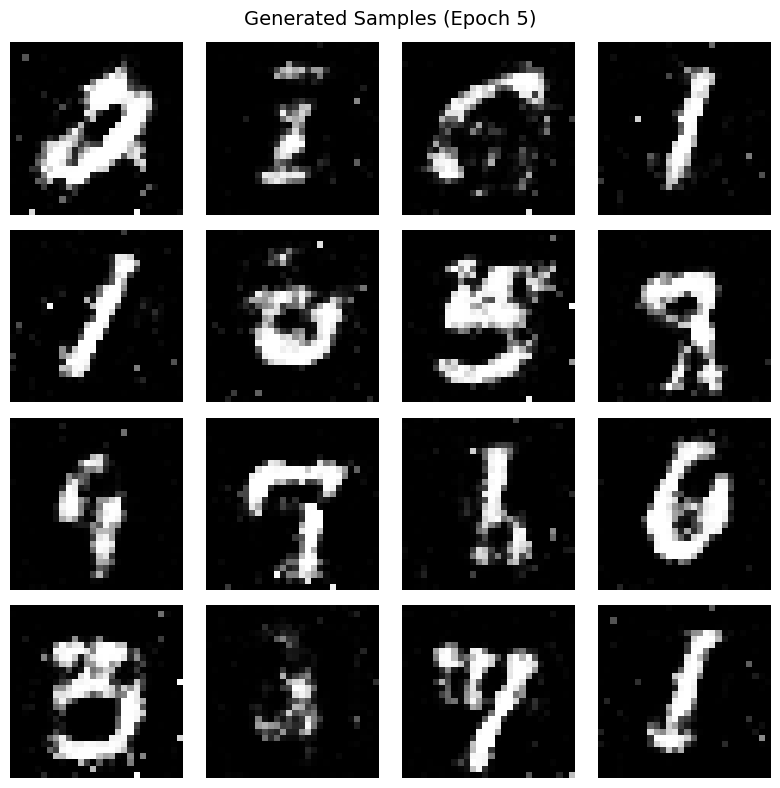


Epoch 6/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 93.74it/s, D_loss=1.4471, G_loss=0.9453, D(x)=0.463, D(G(z))=0.451] 


Epoch 6 Summary:
  Generator Loss: 0.9240
  Discriminator Loss: 1.2929
    - Real Loss: 0.7467
    - Fake Loss: 0.5462

Epoch 7/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.95it/s, D_loss=1.3220, G_loss=0.9607, D(x)=0.496, D(G(z))=0.425] 


Epoch 7 Summary:
  Generator Loss: 0.9062
  Discriminator Loss: 1.3077
    - Real Loss: 0.7527
    - Fake Loss: 0.5549

Epoch 8/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.19it/s, D_loss=1.3644, G_loss=0.8294, D(x)=0.473, D(G(z))=0.439] 


Epoch 8 Summary:
  Generator Loss: 0.8963
  Discriminator Loss: 1.3149
    - Real Loss: 0.7557
    - Fake Loss: 0.5592

Epoch 9/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.48it/s, D_loss=1.3573, G_loss=0.9436, D(x)=0.449, D(G(z))=0.409] 


Epoch 9 Summary:
  Generator Loss: 0.8824
  Discriminator Loss: 1.3224
    - Real Loss: 0.7587
    - Fake Loss: 0.5637

Epoch 10/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.41it/s, D_loss=1.4032, G_loss=0.8130, D(x)=0.465, D(G(z))=0.456] 


Epoch 10 Summary:
  Generator Loss: 0.8741
  Discriminator Loss: 1.3295
    - Real Loss: 0.7611
    - Fake Loss: 0.5684


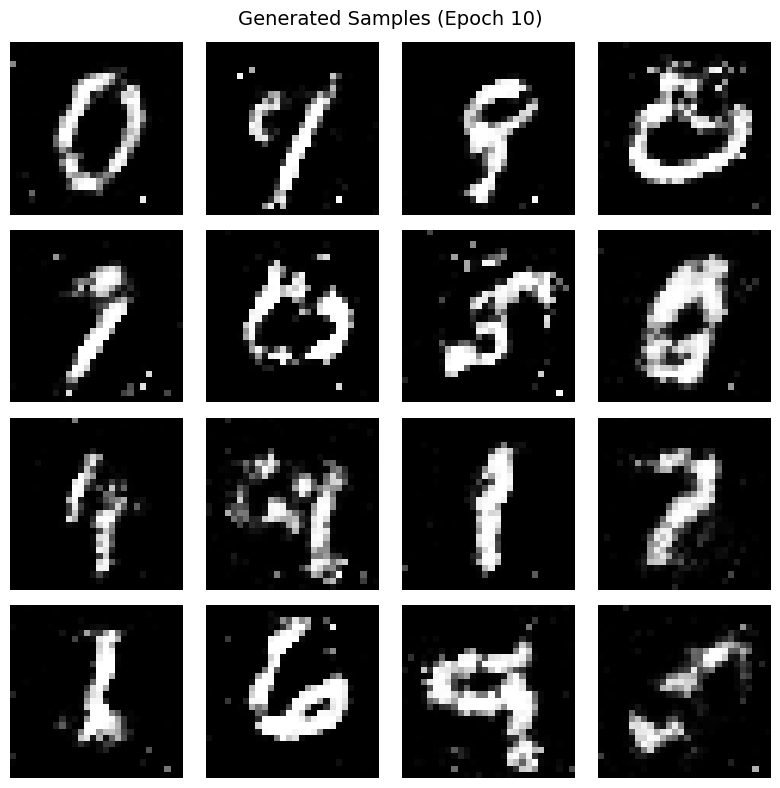


Epoch 11/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.29it/s, D_loss=1.3821, G_loss=0.8399, D(x)=0.458, D(G(z))=0.441] 


Epoch 11 Summary:
  Generator Loss: 0.8652
  Discriminator Loss: 1.3355
    - Real Loss: 0.7636
    - Fake Loss: 0.5719

Epoch 12/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.50it/s, D_loss=1.3868, G_loss=0.8375, D(x)=0.458, D(G(z))=0.435] 


Epoch 12 Summary:
  Generator Loss: 0.8639
  Discriminator Loss: 1.3352
    - Real Loss: 0.7634
    - Fake Loss: 0.5718

Epoch 13/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.25it/s, D_loss=1.4081, G_loss=0.8231, D(x)=0.429, D(G(z))=0.422] 


Epoch 13 Summary:
  Generator Loss: 0.8583
  Discriminator Loss: 1.3394
    - Real Loss: 0.7648
    - Fake Loss: 0.5746

Epoch 14/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 92.46it/s, D_loss=1.3117, G_loss=0.8844, D(x)=0.506, D(G(z))=0.448] 


Epoch 14 Summary:
  Generator Loss: 0.8532
  Discriminator Loss: 1.3411
    - Real Loss: 0.7655
    - Fake Loss: 0.5756

Epoch 15/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.59it/s, D_loss=1.3367, G_loss=0.8813, D(x)=0.465, D(G(z))=0.427] 


Epoch 15 Summary:
  Generator Loss: 0.8492
  Discriminator Loss: 1.3442
    - Real Loss: 0.7673
    - Fake Loss: 0.5769


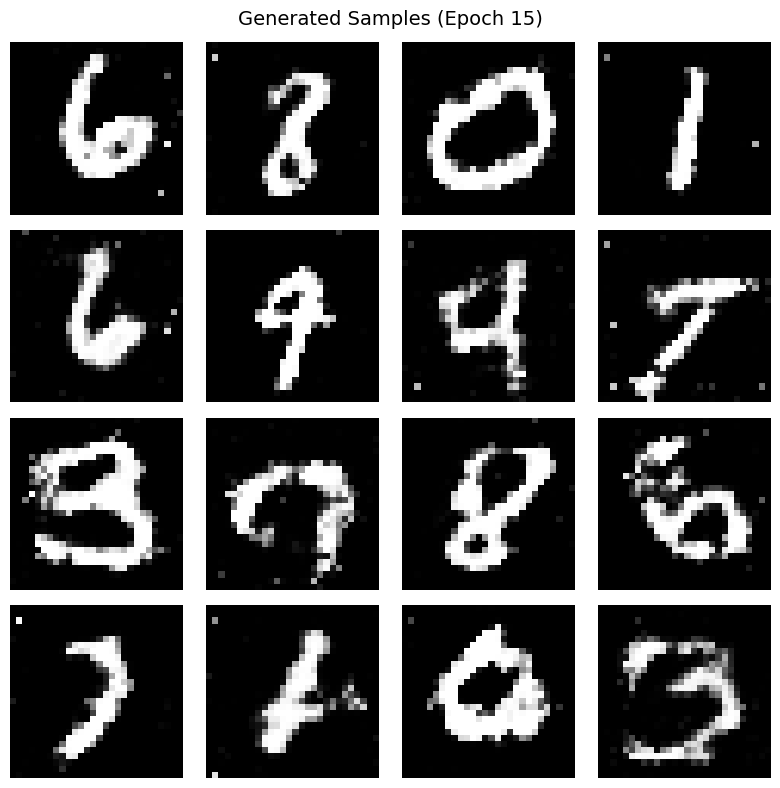


Epoch 16/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.78it/s, D_loss=1.2533, G_loss=0.8193, D(x)=0.563, D(G(z))=0.459] 


Epoch 16 Summary:
  Generator Loss: 0.8462
  Discriminator Loss: 1.3452
    - Real Loss: 0.7672
    - Fake Loss: 0.5780

Epoch 17/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.89it/s, D_loss=1.3990, G_loss=0.8775, D(x)=0.450, D(G(z))=0.447] 


Epoch 17 Summary:
  Generator Loss: 0.8450
  Discriminator Loss: 1.3467
    - Real Loss: 0.7677
    - Fake Loss: 0.5790

Epoch 18/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.35it/s, D_loss=1.3227, G_loss=0.8294, D(x)=0.459, D(G(z))=0.408] 


Epoch 18 Summary:
  Generator Loss: 0.8424
  Discriminator Loss: 1.3478
    - Real Loss: 0.7685
    - Fake Loss: 0.5793

Epoch 19/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.36it/s, D_loss=1.3424, G_loss=0.7997, D(x)=0.471, D(G(z))=0.434] 


Epoch 19 Summary:
  Generator Loss: 0.8405
  Discriminator Loss: 1.3477
    - Real Loss: 0.7678
    - Fake Loss: 0.5798

Epoch 20/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.06it/s, D_loss=1.3583, G_loss=0.7777, D(x)=0.455, D(G(z))=0.433] 


Epoch 20 Summary:
  Generator Loss: 0.8390
  Discriminator Loss: 1.3469
    - Real Loss: 0.7665
    - Fake Loss: 0.5804


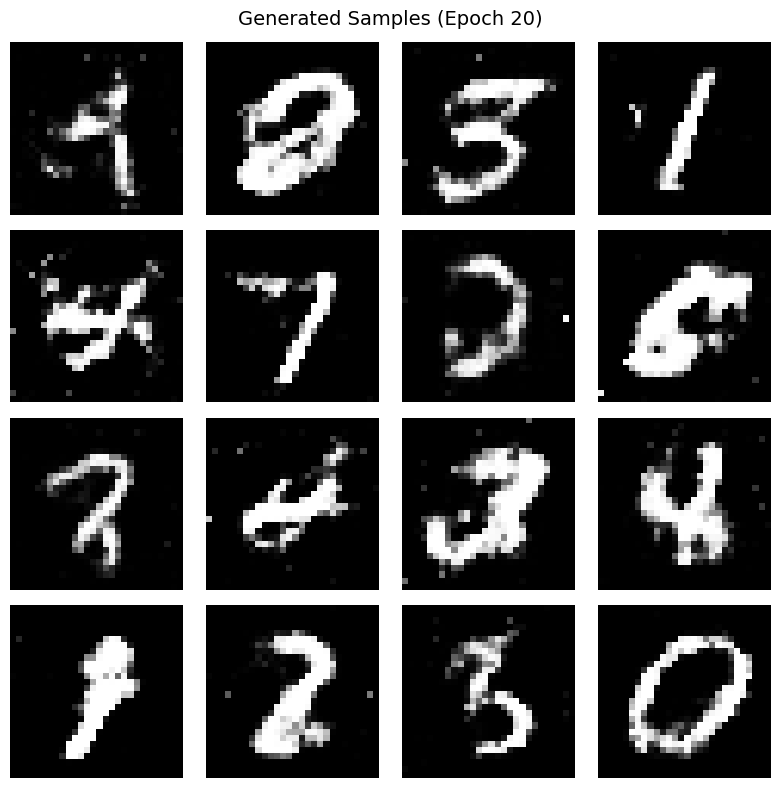


Epoch 21/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.54it/s, D_loss=1.2797, G_loss=0.8237, D(x)=0.476, D(G(z))=0.405] 


Epoch 21 Summary:
  Generator Loss: 0.8359
  Discriminator Loss: 1.3505
    - Real Loss: 0.7692
    - Fake Loss: 0.5813

Epoch 22/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 93.28it/s, D_loss=1.3917, G_loss=0.8133, D(x)=0.455, D(G(z))=0.448] 


Epoch 22 Summary:
  Generator Loss: 0.8348
  Discriminator Loss: 1.3500
    - Real Loss: 0.7687
    - Fake Loss: 0.5812

Epoch 23/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 96.03it/s, D_loss=1.3194, G_loss=0.8002, D(x)=0.487, D(G(z))=0.441] 


Epoch 23 Summary:
  Generator Loss: 0.8350
  Discriminator Loss: 1.3491
    - Real Loss: 0.7678
    - Fake Loss: 0.5813

Epoch 24/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.86it/s, D_loss=1.3055, G_loss=0.8115, D(x)=0.467, D(G(z))=0.415] 


Epoch 24 Summary:
  Generator Loss: 0.8328
  Discriminator Loss: 1.3505
    - Real Loss: 0.7682
    - Fake Loss: 0.5823

Epoch 25/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.91it/s, D_loss=1.2939, G_loss=0.8575, D(x)=0.485, D(G(z))=0.428] 

Epoch 25 Summary:
  Generator Loss: 0.8334
  Discriminator Loss: 1.3503
    - Real Loss: 0.7681
    - Fake Loss: 0.5821


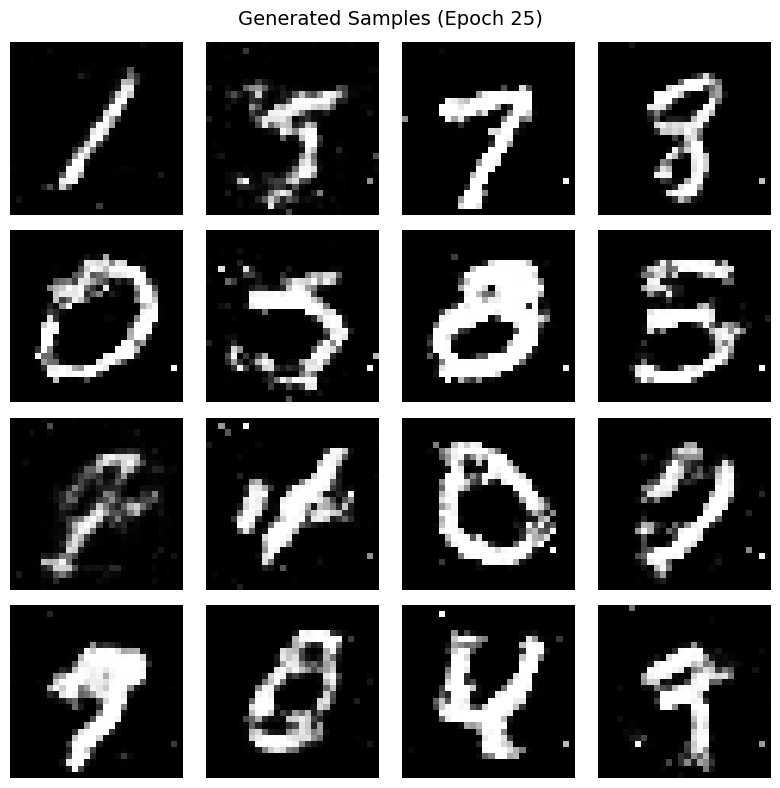


Epoch 26/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.86it/s, D_loss=1.3417, G_loss=0.8384, D(x)=0.453, D(G(z))=0.425] 


Epoch 26 Summary:
  Generator Loss: 0.8314
  Discriminator Loss: 1.3516
    - Real Loss: 0.7693
    - Fake Loss: 0.5823

Epoch 27/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 97.38it/s, D_loss=1.3343, G_loss=0.8641, D(x)=0.469, D(G(z))=0.431] 


Epoch 27 Summary:
  Generator Loss: 0.8304
  Discriminator Loss: 1.3511
    - Real Loss: 0.7685
    - Fake Loss: 0.5826

Epoch 28/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.81it/s, D_loss=1.3394, G_loss=0.8422, D(x)=0.468, D(G(z))=0.426] 


Epoch 28 Summary:
  Generator Loss: 0.8310
  Discriminator Loss: 1.3517
    - Real Loss: 0.7690
    - Fake Loss: 0.5828

Epoch 29/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.90it/s, D_loss=1.3477, G_loss=0.7805, D(x)=0.481, D(G(z))=0.452] 


Epoch 29 Summary:
  Generator Loss: 0.8294
  Discriminator Loss: 1.3523
    - Real Loss: 0.7689
    - Fake Loss: 0.5834

Epoch 30/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.18it/s, D_loss=1.3874, G_loss=0.8813, D(x)=0.448, D(G(z))=0.437] 


Epoch 30 Summary:
  Generator Loss: 0.8277
  Discriminator Loss: 1.3527
    - Real Loss: 0.7693
    - Fake Loss: 0.5835


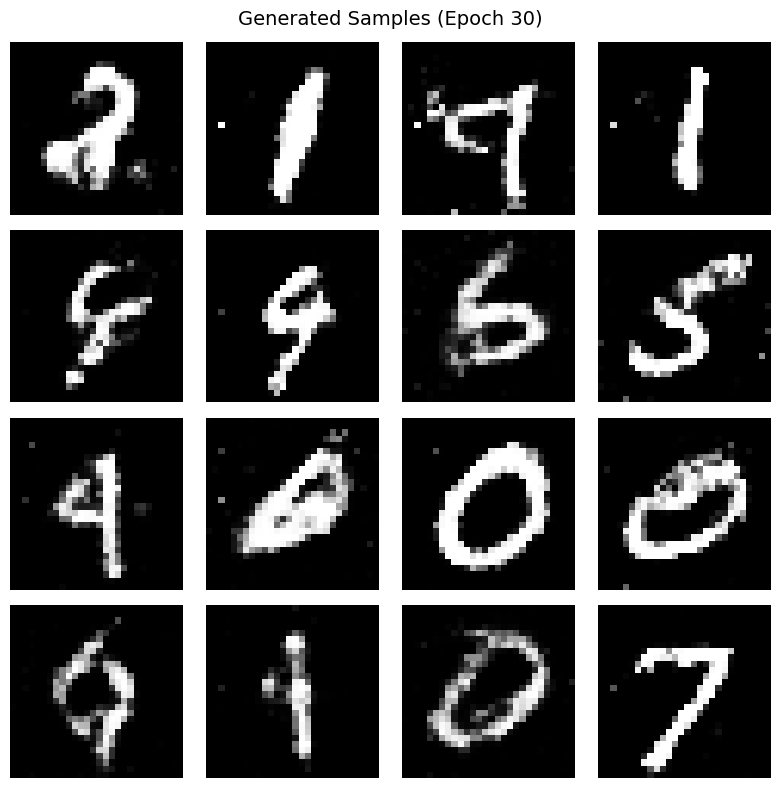


Epoch 31/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.00it/s, D_loss=1.3430, G_loss=0.8329, D(x)=0.447, D(G(z))=0.418] 


Epoch 31 Summary:
  Generator Loss: 0.8260
  Discriminator Loss: 1.3531
    - Real Loss: 0.7693
    - Fake Loss: 0.5838

Epoch 32/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.42it/s, D_loss=1.3472, G_loss=0.8352, D(x)=0.472, D(G(z))=0.443] 


Epoch 32 Summary:
  Generator Loss: 0.8253
  Discriminator Loss: 1.3543
    - Real Loss: 0.7701
    - Fake Loss: 0.5842

Epoch 33/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.70it/s, D_loss=1.3874, G_loss=0.7853, D(x)=0.442, D(G(z))=0.438] 


Epoch 33 Summary:
  Generator Loss: 0.8235
  Discriminator Loss: 1.3554
    - Real Loss: 0.7700
    - Fake Loss: 0.5854

Epoch 34/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.35it/s, D_loss=1.3712, G_loss=0.8362, D(x)=0.444, D(G(z))=0.431] 


Epoch 34 Summary:
  Generator Loss: 0.8220
  Discriminator Loss: 1.3541
    - Real Loss: 0.7691
    - Fake Loss: 0.5850

Epoch 35/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.67it/s, D_loss=1.3326, G_loss=0.8667, D(x)=0.448, D(G(z))=0.410] 


Epoch 35 Summary:
  Generator Loss: 0.8232
  Discriminator Loss: 1.3559
    - Real Loss: 0.7706
    - Fake Loss: 0.5854


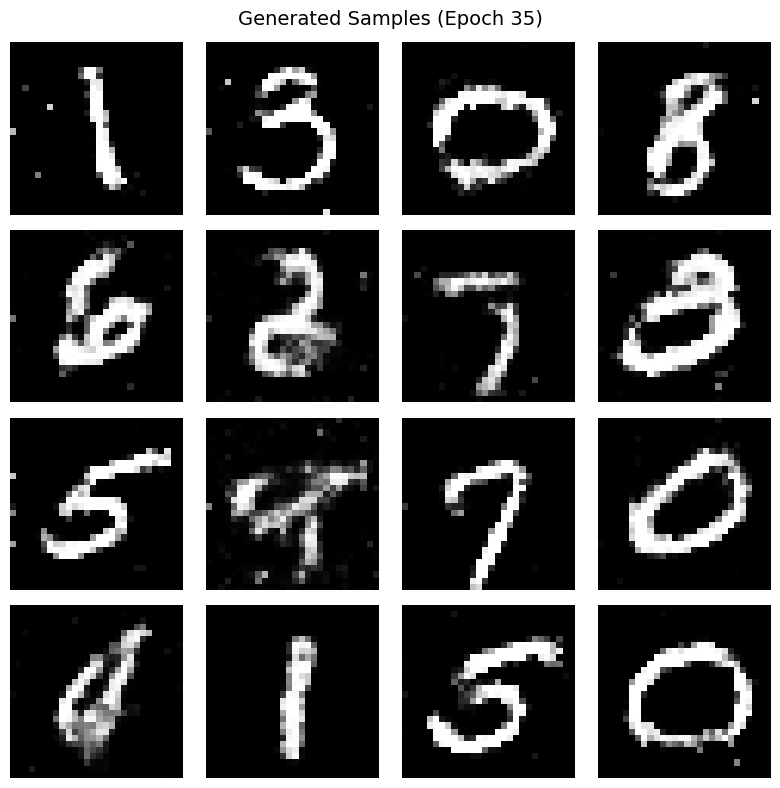


Epoch 36/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.07it/s, D_loss=1.3558, G_loss=0.8444, D(x)=0.469, D(G(z))=0.444] 


Epoch 36 Summary:
  Generator Loss: 0.8219
  Discriminator Loss: 1.3559
    - Real Loss: 0.7706
    - Fake Loss: 0.5853

Epoch 37/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.21it/s, D_loss=1.3728, G_loss=0.8158, D(x)=0.457, D(G(z))=0.442] 


Epoch 37 Summary:
  Generator Loss: 0.8226
  Discriminator Loss: 1.3548
    - Real Loss: 0.7697
    - Fake Loss: 0.5851

Epoch 38/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.01it/s, D_loss=1.2889, G_loss=0.8534, D(x)=0.471, D(G(z))=0.412] 


Epoch 38 Summary:
  Generator Loss: 0.8217
  Discriminator Loss: 1.3559
    - Real Loss: 0.7701
    - Fake Loss: 0.5858

Epoch 39/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.65it/s, D_loss=1.3754, G_loss=0.8382, D(x)=0.459, D(G(z))=0.448] 


Epoch 39 Summary:
  Generator Loss: 0.8197
  Discriminator Loss: 1.3568
    - Real Loss: 0.7708
    - Fake Loss: 0.5860

Epoch 40/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.88it/s, D_loss=1.3436, G_loss=0.8360, D(x)=0.464, D(G(z))=0.433] 


Epoch 40 Summary:
  Generator Loss: 0.8205
  Discriminator Loss: 1.3557
    - Real Loss: 0.7701
    - Fake Loss: 0.5856


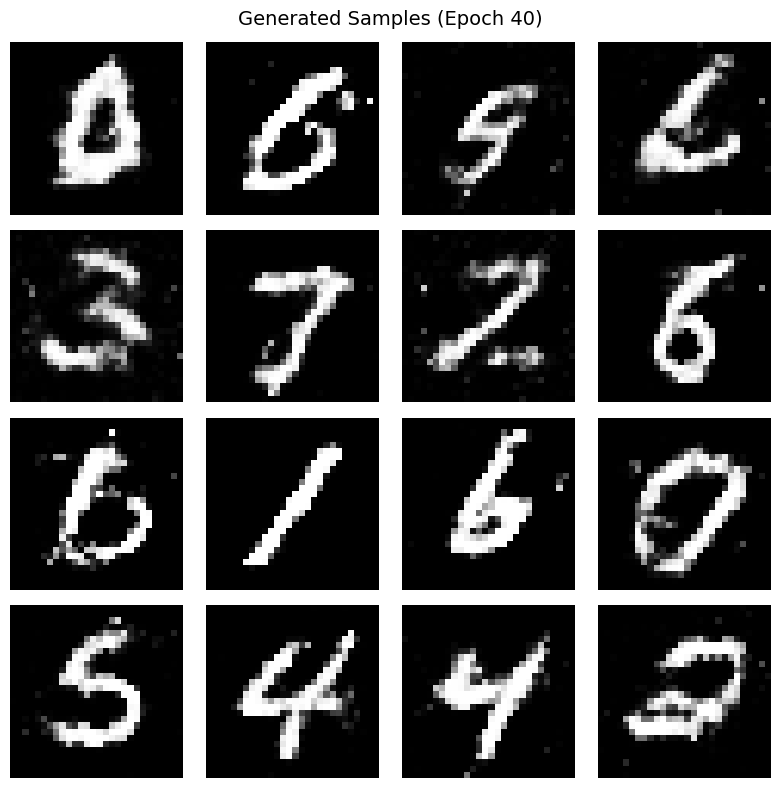


Epoch 41/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.12it/s, D_loss=1.3661, G_loss=0.7682, D(x)=0.450, D(G(z))=0.430] 


Epoch 41 Summary:
  Generator Loss: 0.8220
  Discriminator Loss: 1.3550
    - Real Loss: 0.7700
    - Fake Loss: 0.5850

Epoch 42/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.90it/s, D_loss=1.3312, G_loss=0.8190, D(x)=0.452, D(G(z))=0.414] 


Epoch 42 Summary:
  Generator Loss: 0.8207
  Discriminator Loss: 1.3558
    - Real Loss: 0.7704
    - Fake Loss: 0.5855

Epoch 43/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.00it/s, D_loss=1.3881, G_loss=0.8425, D(x)=0.467, D(G(z))=0.455] 


Epoch 43 Summary:
  Generator Loss: 0.8202
  Discriminator Loss: 1.3555
    - Real Loss: 0.7701
    - Fake Loss: 0.5854

Epoch 44/50


Training: 100%|██████████| 1875/1875 [00:20<00:00, 93.38it/s, D_loss=1.3908, G_loss=0.7812, D(x)=0.464, D(G(z))=0.461] 


Epoch 44 Summary:
  Generator Loss: 0.8212
  Discriminator Loss: 1.3542
    - Real Loss: 0.7696
    - Fake Loss: 0.5846

Epoch 45/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 95.64it/s, D_loss=1.3450, G_loss=0.7926, D(x)=0.450, D(G(z))=0.424] 

Epoch 45 Summary:
  Generator Loss: 0.8207
  Discriminator Loss: 1.3567
    - Real Loss: 0.7710
    - Fake Loss: 0.5857


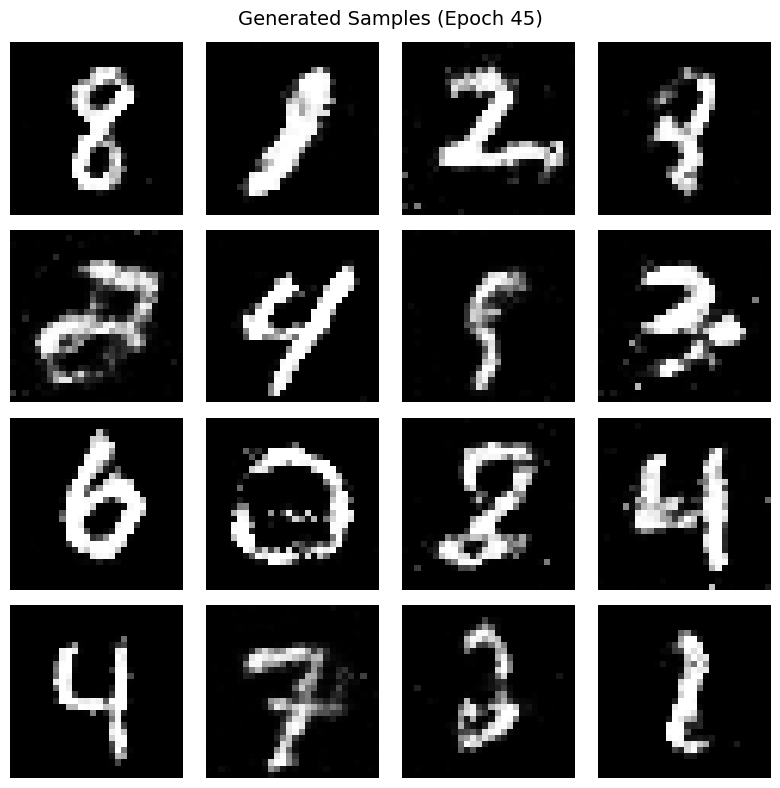


Epoch 46/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 94.77it/s, D_loss=1.3445, G_loss=0.8192, D(x)=0.451, D(G(z))=0.421] 


Epoch 46 Summary:
  Generator Loss: 0.8199
  Discriminator Loss: 1.3565
    - Real Loss: 0.7707
    - Fake Loss: 0.5858

Epoch 47/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 96.59it/s, D_loss=1.3525, G_loss=0.8006, D(x)=0.461, D(G(z))=0.435] 


Epoch 47 Summary:
  Generator Loss: 0.8202
  Discriminator Loss: 1.3573
    - Real Loss: 0.7713
    - Fake Loss: 0.5860

Epoch 48/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 97.78it/s, D_loss=1.3240, G_loss=0.8365, D(x)=0.461, D(G(z))=0.420] 


Epoch 48 Summary:
  Generator Loss: 0.8190
  Discriminator Loss: 1.3560
    - Real Loss: 0.7698
    - Fake Loss: 0.5862

Epoch 49/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 97.41it/s, D_loss=1.3575, G_loss=0.8374, D(x)=0.463, D(G(z))=0.440] 


Epoch 49 Summary:
  Generator Loss: 0.8204
  Discriminator Loss: 1.3561
    - Real Loss: 0.7703
    - Fake Loss: 0.5858

Epoch 50/50


Training: 100%|██████████| 1875/1875 [00:19<00:00, 97.88it/s, D_loss=1.3235, G_loss=0.8364, D(x)=0.478, D(G(z))=0.437] 


Epoch 50 Summary:
  Generator Loss: 0.8194
  Discriminator Loss: 1.3570
    - Real Loss: 0.7710
    - Fake Loss: 0.5860


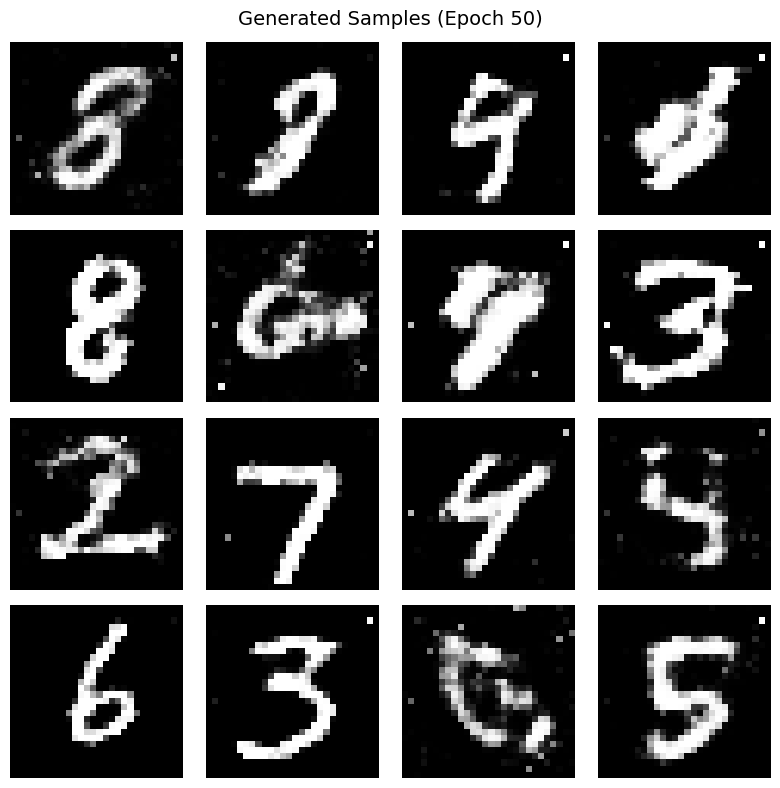


Training completed in 1043.51 seconds
Average time per epoch: 20.87 seconds


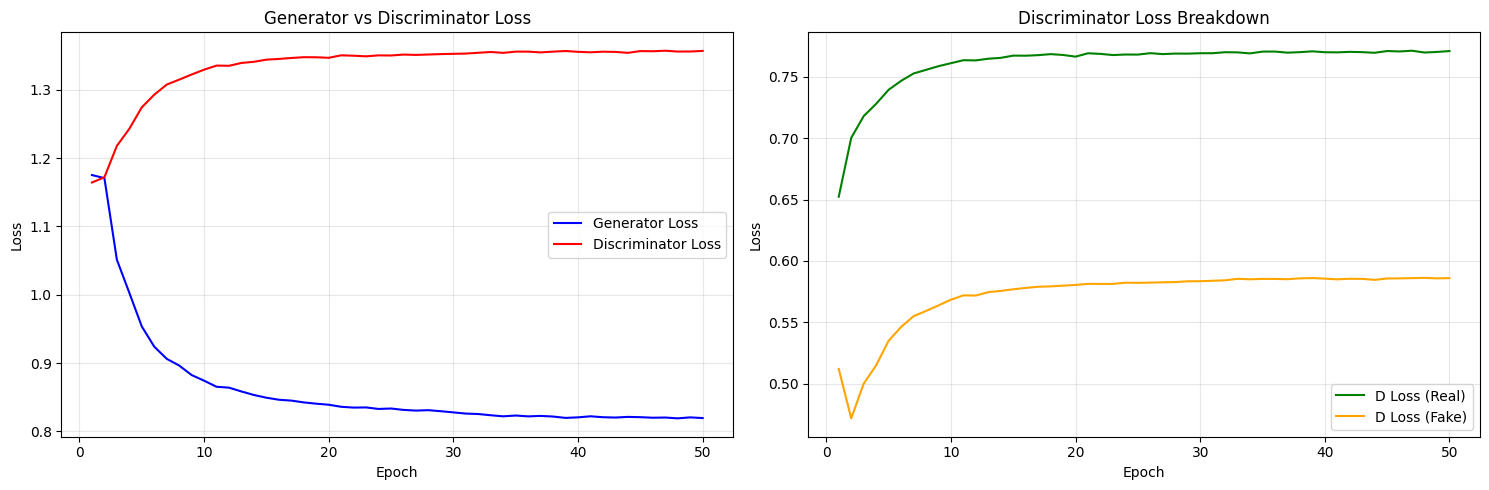


Final generated samples:


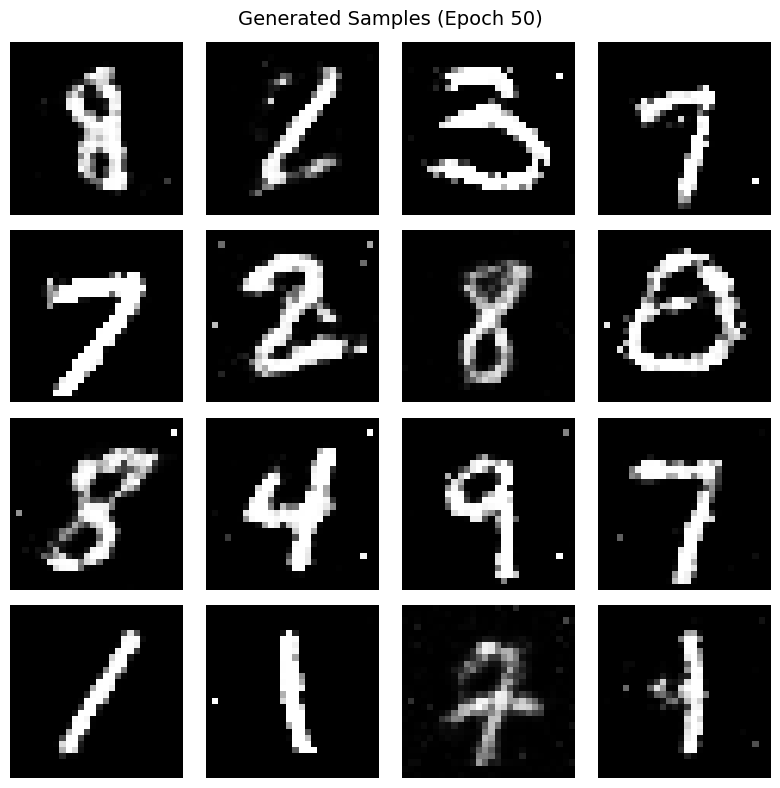

In [33]:
class GANTrainer:
    def __init__(self, generator, discriminator, device, lr=2e-4, beta1=0.5, beta2=0.999, 
                 label_smoothing=True, smooth_real_labels=0.9):
        """
        GAN Trainer with optimized hyperparameters
        
        Args:
            generator: Generator model
            discriminator: Discriminator model  
            device: Training device (cuda/cpu)
            lr: Learning rate for both optimizers
            beta1: Beta1 parameter for Adam (reduced for GAN stability)
            beta2: Beta2 parameter for Adam
            label_smoothing: Whether to apply one-sided label smoothing
            smooth_real_labels: Value for smoothed real labels (default 0.9)
        """
        self.generator = generator.to(device)
        self.discriminator = discriminator.to(device)
        self.device = device
        
        # Optimizers with GAN-specific hyperparameters
        self.optimizer_G = optim.Adam(
            self.generator.parameters(), 
            lr=lr, 
            betas=(beta1, beta2)
        )
        
        self.optimizer_D = optim.Adam(
            self.discriminator.parameters(), 
            lr=lr, 
            betas=(beta1, beta2)
        )
        
        # Loss function
        self.criterion = nn.BCELoss()
        
        # Label smoothing settings
        self.label_smoothing = label_smoothing
        self.smooth_real_labels = smooth_real_labels
        
        # Training statistics
        self.losses_G = []
        self.losses_D = []
        self.losses_D_real = []
        self.losses_D_fake = []
        
        print(f"GAN Trainer initialized:")
        print(f"  Learning rate: {lr}")
        print(f"  Adam betas: ({beta1}, {beta2})")
        print(f"  Label smoothing: {label_smoothing}")
        if label_smoothing:
            print(f"  Smooth real labels: {smooth_real_labels}")
        print(f"  Device: {device}")
    
    def get_labels(self, batch_size, real=True):
        """
        Generate labels for real/fake data with optional smoothing
        
        Args:
            batch_size: Size of the batch
            real: True for real data labels, False for fake data labels
            
        Returns:
            Labels tensor of appropriate shape
        """
        if real:
            if self.label_smoothing:
                # One-sided label smoothing: real labels = 0.9 instead of 1.0
                labels = torch.full((batch_size, 1), self.smooth_real_labels, 
                                  dtype=torch.float32, device=self.device)
            else:
                labels = torch.ones(batch_size, 1, dtype=torch.float32, device=self.device)
        else:
            # Always use 0.0 for fake labels (no smoothing)
            labels = torch.zeros(batch_size, 1, dtype=torch.float32, device=self.device)
        
        return labels
    
    def train_discriminator(self, real_images, noise):
        """
        Train discriminator on both real and fake images
        
        Args:
            real_images: Batch of real images
            noise: Random noise for generating fake images
            
        Returns:
            Dictionary with discriminator losses
        """
        batch_size = real_images.size(0)
        
        # Clear discriminator gradients
        self.optimizer_D.zero_grad()
        
        # === Train on real images ===
        real_labels = self.get_labels(batch_size, real=True)
        real_predictions = self.discriminator(real_images)
        loss_D_real = self.criterion(real_predictions, real_labels)
        
        # === Train on fake images ===
        fake_images = self.generator(noise)
        fake_labels = self.get_labels(batch_size, real=False)
        fake_predictions = self.discriminator(fake_images.detach())  # Detach to avoid training G
        loss_D_fake = self.criterion(fake_predictions, fake_labels)
        
        # Total discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        self.optimizer_D.step()
        
        return {
            'loss_D_total': loss_D.item(),
            'loss_D_real': loss_D_real.item(),
            'loss_D_fake': loss_D_fake.item(),
            'real_predictions': real_predictions.mean().item(),
            'fake_predictions': fake_predictions.mean().item()
        }
    
    def train_generator(self, noise):
        """
        Train generator using non-saturating loss
        
        Args:
            noise: Random noise for generating fake images
            
        Returns:
            Dictionary with generator losses
        """
        batch_size = noise.size(0)
        
        # Clear generator gradients
        self.optimizer_G.zero_grad()
        
        # Generate fake images
        fake_images = self.generator(noise)
        
        # Non-saturating loss: use real labels (1) for fake images
        # This maximizes log(D(G(z))) instead of minimizing log(1-D(G(z)))
        real_labels = self.get_labels(batch_size, real=True)
        fake_predictions = self.discriminator(fake_images)
        loss_G = self.criterion(fake_predictions, real_labels)
        
        loss_G.backward()
        self.optimizer_G.step()
        
        return {
            'loss_G': loss_G.item(),
            'fake_predictions_for_G': fake_predictions.mean().item()
        }
    
    def train_epoch(self, dataloader, noise_dim=100):
        """
        Train both networks for one epoch
        
        Args:
            dataloader: DataLoader for training data
            noise_dim: Dimension of noise vector
            
        Returns:
            Dictionary with epoch statistics
        """
        self.generator.train()
        self.discriminator.train()
        
        epoch_losses_G = []
        epoch_losses_D = []
        epoch_losses_D_real = []
        epoch_losses_D_fake = []
        
        progress_bar = tqdm(dataloader, desc="Training")
        
        for batch_idx, (real_images, _) in enumerate(progress_bar):
            batch_size = real_images.size(0)
            real_images = real_images.to(self.device)
            
            # Generate random noise
            noise = torch.randn(batch_size, noise_dim, device=self.device)
            
            # Train Discriminator
            d_stats = self.train_discriminator(real_images, noise)
            
            # Train Generator
            g_stats = self.train_generator(noise)
            
            # Store losses
            epoch_losses_G.append(g_stats['loss_G'])
            epoch_losses_D.append(d_stats['loss_D_total'])
            epoch_losses_D_real.append(d_stats['loss_D_real'])
            epoch_losses_D_fake.append(d_stats['loss_D_fake'])
            
            # Update progress bar
            progress_bar.set_postfix({
                'D_loss': f"{d_stats['loss_D_total']:.4f}",
                'G_loss': f"{g_stats['loss_G']:.4f}",
                'D(x)': f"{d_stats['real_predictions']:.3f}",
                'D(G(z))': f"{d_stats['fake_predictions']:.3f}"
            })
        
        # Calculate epoch averages
        avg_loss_G = np.mean(epoch_losses_G)
        avg_loss_D = np.mean(epoch_losses_D)
        avg_loss_D_real = np.mean(epoch_losses_D_real)
        avg_loss_D_fake = np.mean(epoch_losses_D_fake)
        
        # Store for plotting
        self.losses_G.append(avg_loss_G)
        self.losses_D.append(avg_loss_D)
        self.losses_D_real.append(avg_loss_D_real)
        self.losses_D_fake.append(avg_loss_D_fake)
        
        return {
            'avg_loss_G': avg_loss_G,
            'avg_loss_D': avg_loss_D,
            'avg_loss_D_real': avg_loss_D_real,
            'avg_loss_D_fake': avg_loss_D_fake
        }
    
    def generate_samples(self, num_samples=64, noise_dim=100):
        """Generate samples for visualization"""
        self.generator.eval()
        
        with torch.no_grad():
            noise = torch.randn(num_samples, noise_dim, device=self.device)
            fake_images = self.generator(noise)
        
        return fake_images
    
    def plot_losses(self):
        """Plot training losses"""
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        
        epochs = range(1, len(self.losses_G) + 1)
        
        # Plot Generator and Discriminator losses
        axes[0].plot(epochs, self.losses_G, label='Generator Loss', color='blue')
        axes[0].plot(epochs, self.losses_D, label='Discriminator Loss', color='red')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Generator vs Discriminator Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
        
        # Plot Discriminator breakdown
        axes[1].plot(epochs, self.losses_D_real, label='D Loss (Real)', color='green')
        axes[1].plot(epochs, self.losses_D_fake, label='D Loss (Fake)', color='orange')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Loss')
        axes[1].set_title('Discriminator Loss Breakdown')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

def visualize_samples(fake_images, epoch=None, num_samples=16):
    """Visualize generated samples"""
    # Convert from [-1,1] to [0,1] for visualization
    fake_images = (fake_images + 1) / 2
    fake_images = torch.clamp(fake_images, 0, 1)
    
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    
    for i in range(num_samples):
        row, col = i // 4, i % 4
        img = fake_images[i].cpu().squeeze()
        axes[row, col].imshow(img, cmap='gray')
        axes[row, col].axis('off')
    
    title = f'Generated Samples (Epoch {epoch})' if epoch else 'Generated Samples'
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def full_training_loop(generator, discriminator, train_loader, epochs=50, noise_dim=100, 
                      lr=2e-4, label_smoothing=True, device=None):
    """
    Complete training loop with visualization
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Initialize trainer
    trainer = GANTrainer(
        generator, discriminator, device, 
        lr=lr, label_smoothing=label_smoothing
    )
    
    print(f"\nStarting GAN training for {epochs} epochs...")
    print("="*60)
    
    start_time = time.time()
    
    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")
        
        # Train for one epoch
        epoch_stats = trainer.train_epoch(train_loader, noise_dim)
        
        # Print epoch summary
        print(f"Epoch {epoch} Summary:")
        print(f"  Generator Loss: {epoch_stats['avg_loss_G']:.4f}")
        print(f"  Discriminator Loss: {epoch_stats['avg_loss_D']:.4f}")
        print(f"    - Real Loss: {epoch_stats['avg_loss_D_real']:.4f}")
        print(f"    - Fake Loss: {epoch_stats['avg_loss_D_fake']:.4f}")
        
        # Generate and show samples every 5 epochs
        if epoch % 5 == 0 or epoch == 1:
            fake_images = trainer.generate_samples(16, noise_dim)
            visualize_samples(fake_images, epoch, num_samples=16)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Average time per epoch: {training_time/epochs:.2f} seconds")
    
    # Plot final losses
    trainer.plot_losses()
    
    # Generate final samples
    print("\nFinal generated samples:")
    final_samples = trainer.generate_samples(16, noise_dim)
    visualize_samples(final_samples, epoch=epochs, num_samples=16)
    
    return trainer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models (using previously defined architectures)
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("Testing training setup...")

# Test with dummy data
batch_size = 32
noise_dim = 100

# Create trainer
trainer = GANTrainer(generator, discriminator, device, label_smoothing=True)

# Test one training step
dummy_images = torch.randn(batch_size, 1, 28, 28).to(device)
dummy_noise = torch.randn(batch_size, noise_dim).to(device)

print("\nTesting discriminator training...")
d_stats = trainer.train_discriminator(dummy_images, dummy_noise)
print(f"D stats: {d_stats}")

print("\nTesting generator training...")
g_stats = trainer.train_generator(dummy_noise)
print(f"G stats: {g_stats}")

print("\nTesting sample generation...")
samples = trainer.generate_samples(16, noise_dim)
print(f"Generated samples shape: {samples.shape}")
print(f"Samples range: [{samples.min():.3f}, {samples.max():.3f}]")

print("\n✓ Training setup verified and ready!")

# Uncomment to run full training
trainer = full_training_loop(generator, discriminator, train_loader, 
                            epochs=50, device=device)